# Overlapping Generation Model, with population growth

**Table of contents**<a id='toc0_'></a>    
- 1. [Model description](#toc1_)    
  - 1.1. [Method of solution](#toc1_1_)    
- 2. [Analytical solution](#toc2_)    
- 3. [Numerical solution](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In this project we will simulate the overlapping generations (OLG) model with **population growth**. 

In [1]:
# Import required packages and tools

# autoreload
%load_ext autoreload
%autoreload 2

# First we import needed extentions, packages 
import numpy as np
from scipy import optimize

# displying
from IPython.display import display

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# model
from OLG_growth_model import OLGModelClass

# importing symbolic math tools
import sympy as sm

# ad-hoc plotting function
from OLG_growth_model import capital_accumulation_plot

## 1. <a id='toc1_'></a>[Model description](#toc0_)

Capital letters are aggregate variables.

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** <font color=blue>Population growth rate</font> is n.
A life consists of two periods, *young* and *old*. 
Young population at time $t$ is $L_t$, while old population is $L_{t-1}$. It holds that:

$$
\begin{aligned}
L_t & = L_{t-1}(1+n) \\ 
\text{with}\ n &>-1
\end{aligned}
$$

**Households:** 
No unemployment is assumed in the young population so labour market clears, with $L_t$ equal to $N_t$, which represents the employed workers in the economy. Each individual supplies one unit of labour. 
At the aggregate level, young individuals earn a <font color=blue>after tax wage</font> $(1-\tau_w)w_{t}N_{t}$.<br>
Consumption as young and old are denoted by $C_{1t}$ and $C_{2t+1}$. 
The <font color=blue>after-tax return on saving</font> is $(1-\tau_{r})r_{t+1}$.<br>
The household decision problem can be represented as following:
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$

In case of $\sigma=1$ we have logarithmic utility and the intertemporal utility function becomes:

$$
\begin{aligned}
U & = log{C_{1t}}+\beta(log{C_{2t+1}}),\,\,\,\beta > -1\\
\end{aligned}
$$

Where $r_{t}$ is the <font color=blue>interest rate on savings</font>, $S_{t}$ are the <font color=blue>total savings</font> and $s_{t}$ is the <font color=blue>saving rate</font>.
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

**Firms:** Firms rent capital $K_{t-1}$ at the <font color=blue>rental rate</font> $r_{t}^{K}$,
and hires labor $N_{t}$ at the <font color=blue>wage rate</font> $w_{t}$. Firms have access
to the CES production function:
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=[\gamma K_{t-1}^{-\theta}+(1-\gamma)L_{t}^{-\theta}]^{\frac{1}{-\theta}},\,\,\,\theta>-1,\gamma\in(0,1)
\end{aligned}
$$

We'll focus on the special case of Cobb-Douglas production function:

$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=A_tK_{t-1}^{\alpha}L_{t}^{1-\alpha}
\end{aligned}
$$

    
<font color=blue>Profits</font> are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose <font color=blue>public consumption (expenditure)</font>, $G_{t}$, and <font color=blue>(income) tax rates</font> $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. <font color=blue>Total tax revenue</font> is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}N_{t}   
\end{aligned}
$$

Where $B_{t-1}$ is the <font color=blue>value of bond outstanding</font>.
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$

Where $r^b_{t}$ 
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**At equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $L_{t}=N_{t}$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

Where $I_{t}$ is investment.

### 1.1. <a id='toc1_1_'></a>[Method of solution](#toc0_)

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},L_{t})=A_t\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},L_{t})=A_t(1-\alpha)L_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.<br>
*Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},L_t)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{L}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
L_{t} & = L_{t-1}(1+n)\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

## 2. <a id='toc1_2_'></a>[Analytical solution](#toc0_)

Given the above model description we attempted to solve part of it analytically.
We try to find the optimal saving rate, given logarythmic period utility function. 
For this purpose we import a function made ad-hoc to solve the household problem analitycally while showing each step of the derivation.
The function provides also characterization for the solving equation. The optimal value of $s_t$ is determined, given the value of beta:

In [2]:
# Calling the ad-hoc analytical solver
# import sympy method for solving recognizing log
from sympy import *
from Analytical_solver import log_analytic

# call ad-hoc analytical solver with beta parameter value = 0.8
log_analytic(beta_val=0.8)

Objective function:


beta*log(C_{2t+1}) + log(c_{1t})



Budget constraints:


Eq(N_{t}*s_t*w_t*(1 - tau_w), S_t)

Eq(N_{t}*w_t*(1 - s_t)*(1 - tau_w), c_{1t})

Eq(S_t*(r_{t+1}*(1 - tau_r) + 1), C_{2t+1})



Substitution of St inside function for consumption of old agents:


Eq(N_{t}*s_t*w_t*(1 - tau_w)*(r_{t+1}*(1 - tau_r) + 1), C_{2t+1})



Substitution of old and young consumption inside objective function:


beta*log(N_{t}*s_t*w_t*(r_{t+1}*tau_r*tau_w - r_{t+1}*tau_r - r_{t+1}*tau_w + r_{t+1} - tau_w + 1)) + log(N_{t}*w_t*(s_t*tau_w - s_t - tau_w + 1))



FOC of objective modified function wrt st:


beta/s_t + (tau_w - 1)/(s_t*tau_w - s_t - tau_w + 1)



Value of st that solves FOC=0:


beta/(beta + 1)



Optimal value of st for beta = 0.8:


0.4444444444444445

## 3. <a id='toc1_4_'></a>[Numerical solution](#toc0_)

We simulate the model for 50 periods, while using some simplifying assumption:
1. Production is Cobb-Douglas ($\theta = 0$)
2. Utility is logarithmic ($\sigma = 1$)
3. The government is not doing anything ($\tau_w=\tau_r=0$, $T_t = G_t = 0$ and $B_t = 0$) 
4. Population growth rate = 0.1

**The analytical steady state when population technology are growing can be defined as:**

$$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{(1+n)(1+1/\beta)}\right)^{\frac{1}{1-\alpha}} $$

In [3]:
# create an instance of the model
model = OLGModelClass()
par = model.par 
sim = model.sim 

# define production parameters
par.production_function = 'cobb-douglas'
par.theta = 0.0
par.alpha = 0.5

# define growth parameters
par.n = 0.1

# define households utility parameter
par.sigma = 1.0
par.beta = 1.0/(1.0+0.4)

# define government parameters
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # G changes to achieve this

# define initial capital as respect to steady state
par.K_lag_ini = 0.5*par.k_ss
par.L_lag_ini = 1.0

# Simulate the model
model.simulate()

initializing the model:
calling .setup()
calling .allocate()
simulation done in 0.09 secs


We can show that the euler equation is being respected at each period:

In [4]:
for t in range(40,45):
    LHS_Euler = sim.C1[t]**(-par.sigma)
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}')

t = 40: euler-error = -0.00000000
t = 41: euler-error = -0.00000000
t = 42: euler-error = -0.00000000
t = 43: euler-error = -0.00000000
t = 44: euler-error = -0.00000000


We can then plot the trend of capital accumulation and compare it to the analytical steady state defined above:

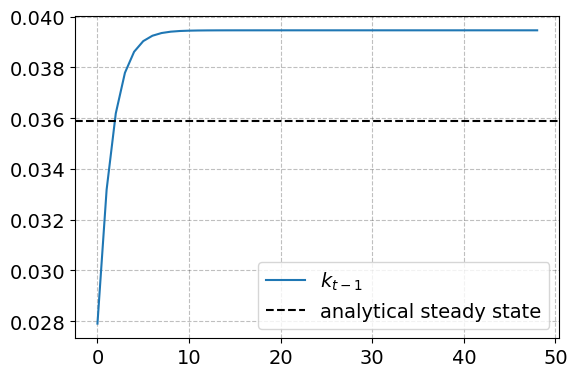

In [5]:
capital_accumulation_plot(par,sim)

We see how $K_{t-1}$ evolves over 50 periods. 
It it seen that $K_{t-1}$ diverge away from steady state and grows exponentially. This is in contrast with the solution suggested analitically above. 
The steady state level of capital is also really close to zero and really near to the starting value of capital.

Trying to figure out a possible reason for the following behaviour, it could be that the introduction of population and technology growth have a positive effect on the accumulation of capital which is not finding any limiting constraint, that could stabilize capital growth as time passes. 
This implies that a particular choice of parameters could put capital accumulation off a balance growth path.

Since this behaviour is sharply divergent from our expectation, we see the possibility of an incorrect mathematical formulation.

Anyhow, we can try and chose another starting level for the capital and see if this would influence our final result: we'll see that the divergent behaviour is confirmed, while the scale of the graph does not permit a better observation of what happens at the starting point.

In [6]:
model2 = OLGModelClass()
par = model2.par 
sim = model2.sim

# Redefining initial capital as respect to steady state
par.K_lag_ini = 1.5*par.k_ss

# simulate the model
model2.simulate()

initializing the model:
calling .setup()
calling .allocate()
simulation done in 0.09 secs


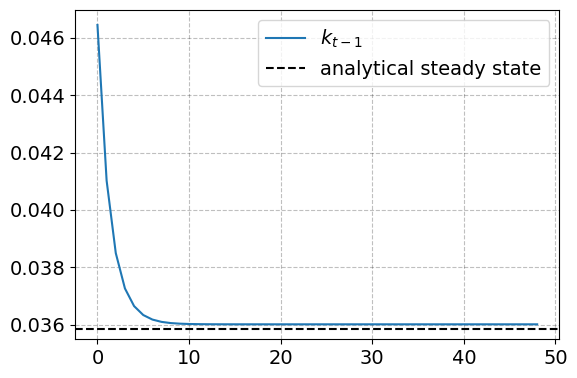

In [7]:
capital_accumulation_plot(par,sim)